In [1]:
%reload_ext autoreload
%autoreload 2

# 导入所有的包
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import tensorflow as tf
import tensorflow.contrib.slim as slim

In [2]:
from PIL import Image

img1 = Image.open('./dataset/train/c0/img_12247.jpg')
img2 = Image.open('./dataset/train/c1/img_100021.jpg')
img3 = Image.open('./dataset/train/c2/img_100108.jpg')
img4 = Image.open('./dataset/train/c3/img_100006.jpg')

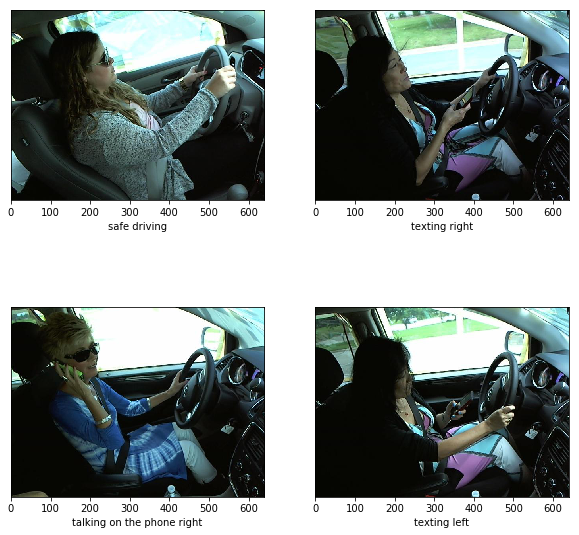

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

nrows = 2
ncols = 2
figsize = (10, 10)
_, figs = plt.subplots(nrows, ncols, figsize=figsize)
figs[0, 0].imshow(img1)
figs[0, 0].axes.set_xlabel('safe driving')
figs[0, 0].axes.get_yaxis().set_visible(False)
figs[0, 1].imshow(img2)
figs[0, 1].axes.set_xlabel('texting right')
figs[0, 1].axes.get_yaxis().set_visible(False)
figs[1, 0].imshow(img3)
figs[1, 0].axes.set_xlabel('talking on the phone right')
figs[1, 0].axes.get_yaxis().set_visible(False)
figs[1, 1].imshow(img4)
figs[1, 1].axes.set_xlabel('texting left')
figs[1, 1].axes.get_yaxis().set_visible(False)

## 读入数据及预处理

接下来读入数据,用 tf.data 方法可以非常方便地操作

首先从`dataset/driver_imgs_list.csv`中读取图片路径以及标签列表

In [4]:
import os
import csv

image_dir = 'dataset/train_valid/'

image_names = []
image_labels = []

with open('dataset/driver_imgs_list.csv') as f:
    f_csv = csv.DictReader(f)
    for row in f_csv:
        classname = row['classname']
        image_labels.append(int(classname[-1]))
        image_names.append(os.path.join(image_dir, classname, row['img']))

确定训练集和验证集

In [5]:
NUM_EXAMPLES_OF_TRAIN = 20000
NUM_EXAMPLES_OF_VALID = len(image_names) - NUM_EXAMPLES_OF_TRAIN

train_names, train_labels = image_names[:NUM_EXAMPLES_OF_TRAIN], image_labels[:NUM_EXAMPLES_OF_TRAIN]
valid_names, valid_labels = image_names[NUM_EXAMPLES_OF_TRAIN:], image_labels[NUM_EXAMPLES_OF_TRAIN:]

使用`tf.data`快速构造读取数据函数

In [6]:
def read(names, labels, batch_size=None, num_epoch=None, shuffle=False, phase='train'):
    def _read_img(name):
        #TODO
        # 给定图像名称tensor, 输出3维浮点值图像
        content = tf.read_file(name)
        image = tf.image.decode_image(content, channels=3)
        image.set_shape((None, None, 3))
        image = tf.cast(image, dtype=tf.float32)
        
        return image
    
    def _train_preprocess(img):
        #TODO
        # 对训练集图像预处理
        # 例如resize到固定大小,翻转,调整对比度等等
        img_resized = tf.image.resize_images(img, (256, 256))
        img_normed = tf.image.per_image_standardization(img_resized)
        
        return img_normed
    
    def _eval_preprocess(img):
        #TODO
        # 对验证集, 测试集图像预处理
        # 例如resize到固定大小等等
        img_resized = tf.image.resize_images(img, (256, 256))
        img_normed = tf.image.per_image_standardization(img_resized)
        
        return img_normed
    
    #TODO
    # 构造图像名称 dataset
    name_dataset = tf.data.Dataset.from_tensor_slices(names)
    
    #TODO
    # 通过 map 函数调用 _read_img 构造图像 dataset
    image_dataset = name_dataset.map(_read_img)
    
    if phase == 'train':
        #TODO
        # 通过 map 函数对训练集图像进行处理
        image_dataset = image_dataset.map(_train_preprocess)
    else:
        #TODO
        # 通过 map 函数对验证集,测试集图像进行处理
        image_dataset = image_dataset.map(_eval_preprocess)

    #TODO
    # 构造图像标签 dataset
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)
    
    #TODO
    # 将图像以及图像标签 dataset 通过 zip 合并成一个 dataset
    dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
    
    #TODO
    # 设置 dataset 的 epoch
    dataset = dataset.repeat(num_epoch)
    
    #TODO
    # 在需要 shuffle 时, 对 dataset 进行 shuffle
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    #TODO
    # 在需要进行 batch 时, 对 dataset 进行 batch
    if batch_size is not None:
        dataset = dataset.batch(batch_size)
    
    #TODO
    # 构造 dataset 的迭代器
    iterator = dataset.make_one_shot_iterator()

    #TODO
    # 获取 dataset 的元素
    image, label = iterator.get_next()

    return image, label

In [7]:
batch_size = 50

train_images, train_labels = read(train_names, train_labels, batch_size=batch_size, shuffle=True, phase='train')
valid_images, valid_labels = read(valid_names, valid_labels, batch_size=batch_size, shuffle=False, phase='valid')

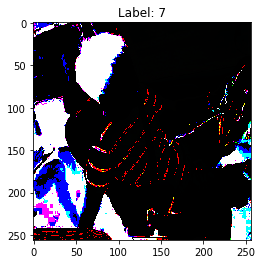

In [12]:
# 测试
# =========这里不要修改=========
import numpy as np

with tf.Session() as sess:
    img_fetch, label_fetch = sess.run([train_images, train_labels])
    assert img_fetch.ndim == 4, '图像维数 != 4'
    assert label_fetch.ndim == 1, '标签维数 != 1'
    plt.imshow(np.uint8(img_fetch[0]))
    plt.title('Label: %d' % label_fetch[0])

## 构建模型

读取数据完成后, 我们需要使用 CNN 构建从图像到预测 label 的模型, 可以自己构造模型, 也可以使用`TF-Slim`中预置的模型函数来构造, 第二种方式的好处是我们可以使用在 imagenet 比赛中训练好的与训练模型, 也就是之前提到的 fine-tune 策略.

两种方式都可以, 下面你将可以使用自己的方式去构造这个分类模型

In [13]:
from tensorflow.contrib.slim.python.slim.nets import resnet_v2

In [15]:
def model(inputs, num_classes, is_training=False, scope='model', reuse=None):
    '''
    function to build forward model.
    
    Arguments:
      inputs: 4维输入图像tensor.
              
      num_classes: 分类数.
                   
      is_training: 对使用 BN 层的神经网络非常有用, 你可以使用它或者不使用.
                   
      scope: 变量域的名称.
             
      reuse: 是否需要重用该变量域下的变量.
      
    Return:
      output: 预测模型在使用最后一个 softmax 或者 sigmoid 之前的输出.
    '''
    #TODO
    # 构造你自己的预测模型
    
    with slim.arg_scope(resnet_v2.resnet_arg_scope(weight_decay=0.0005)):
        logits, endpts = resnet_v2.resnet_v2_50(inputs, num_classes, is_training=is_training, reuse=reuse, scope=scope)
    output = tf.squeeze(logits, [1, 2], name='Output')
    
    return output

In [17]:
is_training = tf.placeholder(tf.bool, name='is_training')

train_out = model(train_images, num_classes=10, is_training=is_training)
valid_out = model(valid_images, num_classes=10, is_training=is_training, reuse=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [18]:
# 测试
# =========这里不要修改=========

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_fetch = sess.run(train_out, feed_dict={is_training: False})
    assert output_fetch.ndim == 2, '网络输出维数 != 2'
    assert output_fetch.shape[-1] == 10, '输出类别数 != 10'

### 构建 loss 函数,计算正确率和构造优化算法

In [19]:
#TODO
# 计算 loss

train_loss = tf.losses.sparse_softmax_cross_entropy(train_labels, train_out)
valid_loss = tf.losses.sparse_softmax_cross_entropy(valid_labels, valid_out)

In [20]:
#TODO
# 计算概率

train_prob = tf.nn.softmax(train_out)
valid_prob = tf.nn.softmax(valid_out)

In [21]:
#TODO
# 计算 accuracy

train_acc = tf.reduce_mean(tf.cast(tf.equal(train_labels, tf.argmax(train_prob, axis=-1, output_type=tf.int32)), dtype=tf.float32))
valid_acc = tf.reduce_mean(tf.cast(tf.equal(valid_labels, tf.argmax(valid_prob, axis=-1, output_type=tf.int32)), dtype=tf.float32))

In [22]:
#TODO
# 定义优化方法

opt = tf.train.AdamOptimizer(0.001, 0.9)

如果你的预测模型中使用了 BN 层, 那么完成 **下面两条** 内容, 否则跳过

In [23]:
#TODO
# 得到所有 bn 更新算子

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

In [24]:
#TODO
# 构造训练方法

with tf.control_dependencies(update_ops):
    train_op = opt.minimize(train_loss)

如果你的模型没有使用 BN 层, 完成 **下面一条** 内容

In [ ]:
#TODO
# 构造训练 op

train_op = None

In [25]:
# 测试
# =========这里不要修改=========

grads = tf.gradients(train_loss, tf.trainable_variables())
assert None not in grads, 'loss 对某参数不可微分'

## 开始训练

当构建好了前面的过程,我们就可以开始训练了,整个训练的框架已经写好,需要做的就是在需要的地方补充完整的代码

In [26]:
# 训练的 epochs 数目
max_epoch = 50

下面是训练的代码,你只需要填写其中的**todo**代码

**注意:如果发现显存超过限制,可以改小 batch size**

In [27]:
def train(train_op, train_loss, train_acc, max_epoch, 
          is_training=None, valid_loss=None, valid_acc=None, save_path=None, pretrained_model=None):
    '''
    训练函数.
    
    Arguments:
      train_op: 训练 op
      
      train_loss: 作用在训练集上的 loss
      
      train_acc: 作用在训练集上的 accuracy
      
      max_epoch: 训练最大步长
      
      is_training: 使用 BN 层时的 placeholder
      
      valid_loss: 作用在验证集上的 loss
      
      valid_acc: 作用在验证集上的 accuracy
      
      save_path: 希望保存的模型路径
      
      pretrained_model: 希望使用的与训练模型路径
    '''
    # 开始训练
    freq_print = NUM_EXAMPLES_OF_TRAIN // 10
    
    log_dir = 'log'

    if pretrained_model is not None:
        #TODO
        # 找到所有需要 finetune 的变量
        vars_to_finetune = {}

        for var in tf.model_variables():
            if 'logit' not in var.op.name:
                var_name_in_ckpt = var.op.name.replace('model', 'resnet_v2_50')
                vars_to_finetune[var_name_in_ckpt] = var

        vars_to_init = filter(lambda var: var not in vars_to_finetune.values(), tf.global_variables())
        
        #TODO
        # 生成一个对上面变量的加载器
        restorer = tf.train.Saver(vars_to_finetune)
    
    if save_path is not None:
        #TODO
        # 生成一个空参数的变量保存器
        saver = tf.train.Saver()
    
    sess = tf.Session()
        
    graph_writer = tf.summary.FileWriter(log_dir, graph=sess.graph)

    if pretrained_model is not None:
        #TODO
        # 使用加载器恢复变量的数值,并初始化其他变量
        sess.run(tf.variables_initializer(vars_to_init))
        restorer.restore(sess, pretrained_model)
    else:
        #TODO
        # 初始化所有变量
        sess.run(tf.global_variables_initializer())

    curr_epoch = 0
    curr_step = 0
    curr_valid_step = 0

    running_loss = 0
    running_acc = 0

    metric_log = dict()
    metric_log['train_loss'] = list()
    metric_log['train_acc'] = list()
    metric_log['valid_loss'] = list()
    metric_log['valid_acc'] = list()

    while curr_epoch < max_epoch:
        if is_training is not None:
            # TODO
            # 运行训练 op, 对 bool 型占位符 is_training 进行赋值
            train_feed_dict = {is_training: True}

            # TODO
            # 运行训练 op, 同时输出当前训练 batch 上的 loss 和 accuracy
            _, batch_loss, batch_acc = sess.run([train_op, train_loss, train_acc], feed_dict=train_feed_dict)
        else:
            #TODO
            # 运行训练 op, 同时输出当前训练 batch 上的 loss 和 accuracy
            _, batch_loss, batch_acc = sess.run([train_op, train_loss, train_acc])

        running_loss += batch_loss
        running_acc += batch_acc

        curr_step += batch_size

        if curr_step // freq_print > (curr_step - batch_size) // freq_print:
            print('[{}]/[{}], train loss: {:.3f}, train acc: {:.3f}'.format(
                curr_step, NUM_EXAMPLES_OF_TRAIN, running_loss / curr_step * batch_size, 
                running_acc / curr_step * batch_size))

        if curr_step > NUM_EXAMPLES_OF_TRAIN:
            # 当前 epoch 结束
            curr_epoch += 1

            metric_log['train_loss'].append(running_loss / curr_step * batch_size)
            metric_log['train_acc'].append(running_acc / curr_step * batch_size)

            if (valid_loss is not None and valid_acc is not None):
                running_loss = 0
                running_acc = 0

                if is_training is not None:
                    # TODO
                    # 计算验证集上所有样本的 loss 和 accuracy, 对 bool 型占位符 is_training 进行赋值
                    eval_feed_dict = {is_training: False}

                    while curr_valid_step < NUM_EXAMPLES_OF_VALID:
                        # TODO
                        # 输出当前验证 batch 上的 loss 和 accuracy

                        batch_loss, batch_acc = sess.run([valid_loss, valid_acc], feed_dict=eval_feed_dict)
                        running_loss += batch_loss
                        running_acc += batch_acc
                        curr_valid_step += batch_size
                else:
                    # TODO
                    # 计算验证集上所有样本的 loss 和 accuracy, 对 bool 型占位符 is_training 进行赋值

                    while curr_valid_step < NUM_EXAMPLES_OF_VALID:
                        # TODO
                        # 输出当前验证 batch 上的 loss 和 accuracy

                        batch_loss, batch_acc = sess.run([valid_loss, valid_acc])
                        running_loss += batch_loss
                        running_acc += batch_acc
                        curr_valid_step += batch_size

                metric_log['valid_loss'].append(running_loss / curr_valid_step * batch_size)
                metric_log['valid_acc'].append(running_acc / curr_valid_step * batch_size)

                curr_valid_step = curr_valid_step % NUM_EXAMPLES_OF_VALID

                print_str = 'epoch: {}, train loss: {:.3f}, train acc: {:.3f}, valid loss: {:.3f}, valid acc: {:.3f}'.format(
            curr_epoch, metric_log['train_loss'][-1], metric_log['train_acc'][-1], 
            metric_log['valid_loss'][-1], metric_log['valid_acc'][-1])

            else:
                print_str = 'epoch: {}, train loss: {:.3f}, train acc: {:.3f}'.format(curr_epoch, 
                                metric_log['train_loss'][-1], metric_log['train_acc'][-1])

            print(print_str)
            print()

            curr_step = curr_step % NUM_EXAMPLES_OF_TRAIN
            running_loss = 0
            running_acc = 0
            
    
    # =======不要修改这里的内容========
    # 保存模型
    if save_path is not None:
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        saved_path = saver.save(sess, '%s/model.ckpt' % save_path)
        print('model saved to %s' % saved_path)
        
    sess.close()
    
    # 可视化
    if valid_loss is not None and valid_acc is not None:
        nrows = 2
        ncols = 2
        figsize = (10, 10)
        _, figs = plt.subplots(nrows, ncols, figsize=figsize)
        figs[0, 0].plot(metric_log['train_loss'])
        figs[0, 0].axes.set_xlabel('train loss')
        figs[0, 1].plot(metric_log['train_acc'])
        figs[0, 1].axes.set_xlabel('train acc')
        figs[1, 0].plot(metric_log['valid_loss'])
        figs[1, 0].axes.set_xlabel('valid loss')
        figs[1, 1].plot(metric_log['valid_acc'])
        figs[1, 1].axes.set_xlabel('valid acc')
    else:
        nrows = 1
        ncols = 2
        figsize= (10, 5)
        _, figs = plt.subplots(nrows, ncols, figsize=figsize)
        figs[0].plot(metric_log['train_loss'])
        figs[0].axes.set_xlabel('train loss')
        figs[1].plot(metric_log['train_acc'])
        figs[1].axes.set_xlabel('train acc')

INFO:tensorflow:Restoring parameters from pretrained_models/resnet_v2_50/model.ckpt
[2000]/[20000], train loss: 0.360, train acc: 0.887
[4000]/[20000], train loss: 0.333, train acc: 0.901
[6000]/[20000], train loss: 0.333, train acc: 0.902
[8000]/[20000], train loss: 0.289, train acc: 0.914
[10000]/[20000], train loss: 0.276, train acc: 0.920
[12000]/[20000], train loss: 0.267, train acc: 0.924
[14000]/[20000], train loss: 0.250, train acc: 0.928
[16000]/[20000], train loss: 0.250, train acc: 0.928
[18000]/[20000], train loss: 0.254, train acc: 0.927
[20000]/[20000], train loss: 0.258, train acc: 0.926
epoch: 1, train loss: 0.258, train acc: 0.926, valid loss: 103.610, valid acc: 0.142

model saved to tmp/model.ckpt


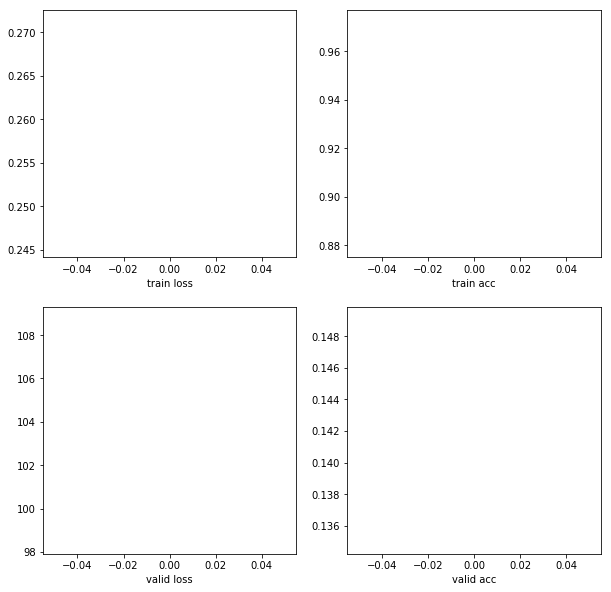

In [29]:
train(train_op, train_loss, train_acc, 1, is_training, valid_loss, valid_acc, save_path='tmp', pretrained_model='pretrained_models/resnet_v2_50/model.ckpt')

通过上面的结果，我们已经将模型跑起来了，那么你的下一个工作就是不断地调参，将验证集的准确率调高，具体的调参方式在课上已经讲过了，比如增加更多的数据增强，或者使用学习率衰减等等，可以通过输出的结果和画出的图像来判断最后模型的好坏

**注意：可能在调参的过程中会出现显存超过限制，这是因为前面一个模型没有释放，所以最好每次调参都重新启动这个 notebook**

当你调完参数之后，得到了一个最优的模型训练方式，那么可以重新训练模型，因为前面我们将数据集拆分成了训练集和验证集两个部分帮助我们调参，现在我们使用完整的数据集重新进行训练以便结果的提交

In [30]:
# 清空当前图
tf.reset_default_graph()

In [34]:
import pandas as pd

from utils import read_test, predict_result

In [32]:
test_names, test_images = read_test('dataset/test/')

In [35]:
submission = predict_result(test_images, test_names, 'tmp/model.ckpt', model)

INFO:tensorflow:Restoring parameters from tmp/model.ckpt
1000 done!
2000 done!
3000 done!
4000 done!
5000 done!
6000 done!
7000 done!
8000 done!
9000 done!
10000 done!
11000 done!
12000 done!
13000 done!
14000 done!
15000 done!
16000 done!
17000 done!
18000 done!
19000 done!
20000 done!
21000 done!
22000 done!
23000 done!
24000 done!
25000 done!
26000 done!
27000 done!
28000 done!
29000 done!
30000 done!
31000 done!
32000 done!
33000 done!
34000 done!
35000 done!
36000 done!
37000 done!
38000 done!
39000 done!
40000 done!
41000 done!
42000 done!
43000 done!
44000 done!
45000 done!
46000 done!
47000 done!
48000 done!
49000 done!
50000 done!
51000 done!
52000 done!
53000 done!
54000 done!
55000 done!
56000 done!
57000 done!
58000 done!
59000 done!
60000 done!
61000 done!
62000 done!
63000 done!
64000 done!
65000 done!
66000 done!
67000 done!
68000 done!
69000 done!
70000 done!
71000 done!
72000 done!
73000 done!
74000 done!
75000 done!
76000 done!
77000 done!
78000 done!
79000 done!


In [36]:
idx_to_class = {}
for i in range(10):
    idx_to_class[i] = 'c%d' % i

In [37]:
submission.columns = [['img'] + [i for i in idx_to_class.values()]]

In [38]:
submission.to_csv('./submission.csv', index=False)

通过运行上面的程序，我们能够在根目录下得到一个提交的csv文件，叫做`submission.csv`，最后只需要将这个文件提交到[kaggle的比赛界面](https://www.kaggle.com/c/state-farm-distracted-driver-detection/leaderboard)即可获得比赛的成绩。